Hướng dẫn train model trên Google Colab với Pytorch
====



## Khởi tạo môi trường


In [8]:
!apt-get install -y -qq software-properties-common module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null

(Reading database ... 144487 files and directories currently installed.)
Preparing to unpack .../module-init-tools_24-1ubuntu3.5_all.deb ...
Unpacking module-init-tools (24-1ubuntu3.5) over (24-1ubuntu3.4) ...
Preparing to unpack .../software-properties-common_0.96.24.32.14_all.deb ...
Unpacking software-properties-common (0.96.24.32.14) over (0.96.24.32.13) ...
Preparing to unpack .../python3-software-properties_0.96.24.32.14_all.deb ...
Unpacking python3-software-properties (0.96.24.32.14) over (0.96.24.32.13) ...
Setting up module-init-tools (24-1ubuntu3.5) ...
Setting up python3-software-properties (0.96.24.32.14) ...
Setting up software-properties-common (0.96.24.32.14) ...
Processing triggers for dbus (1.12.2-1ubuntu1.2) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


Cài đặt `google-drive` package

In [9]:
!apt-get -y install -qq google-drive-ocamlfuse fuse

Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144487 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.22-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.22-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.22-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


Tạo đường dẫn gdrive vào colab notebook

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Pytorch cơ bản

Import pytorch

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

### Neural Net

Một class neural network xử lý ảnh cơ bản có dạng như sau, trong đó:
* `__init__()` khởi tạo các layer
* `forward(x)` nhận vào input data và trả về output sau khi đi đi qua các layer



In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolution layers
        # 1 input image channel, 6 output channels, 3x3 square convolution
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # Fully connected layers y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        print(x.size())
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        print(x.size())
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()

`print(net)` cho biết thông số các layer có trong mạng:

In [ ]:
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Quá trình tính toán được biểu diễn như sau:

```
input -> conv1 -> relu -> maxpool2d -> conv2 -> relu -> maxpool2d
      -> view -> fc1 -> relu -> fc2 -> relu -> fc3 -> output
```

**Lưu ý**: Để feed data từ convolution layer (conv2) sang fully connected layer (fc1), cần xác định `input_channels` của fc1

VD: `input` là ảnh có kích thước `32 x 32` thì `input_channels` của fc1 sẽ là
```
conv_size = 3
conv_output_channels = 16
pool_size = 2
input_channels = conv_output_channels * ((32 - conv_size + 1) / pool_size - 3 + 1) / 2)**2
               = 16 * (((32 - 3 + 1) / 2 - 3 + 1) / 2)**2
               = 16 * 6 * 6
```

Đối với model xử lý ảnh mỗi input sẽ có dạng 1 tensor `[số lượng x số kênh màu x chiều dài x chiều rộng]`

Ví dụ đưa một bức ảnh vào model được output như sau:

In [ ]:
input_img = torch.randn(1, 3, 32, 32)
output = net(input_img)
print(output)

torch.Size([1, 6, 15, 15])
torch.Size([1, 16, 6, 6])
tensor([[-0.1019,  0.0323,  0.0863, -0.1607, -0.0677,  0.1106,  0.0578,  0.0021,
         -0.0985, -0.0082]], grad_fn=<AddmmBackward>)


### Dataset

Builtin của pytorch, hỗ trợ thiết kế dataset

In [20]:
from torchvision.datasets.folder import ImageFolder, default_loader
from torchvision.datasets.utils import download_url, check_integrity

VD dataset chó mèo

In [24]:
import os
import zipfile
class DogCatDataset(ImageFolder):
    '''
        folder structure

        └── dogscats
            ├── sample
            │   ├── train
            │   │   ├── cats
            │   │   └── dogs
            │   └── valid
            │       ├── cats
            │       └── dogs
            ├── train
            │   ├── cats
            │   └── dogs
            └── valid
                ├── cats
                └── dogs
    '''

    url = "http://files.fast.ai/data/dogscats.zip"
    filename = "dogscats.zip"
    checksum = "aef22ec7d472dd60e8ee79eecc19f131"

    def __init__(
        self,
        root: str,
        suffix: str,
        transform=None,
        target_transform=None,
        loader=default_loader,
        download=False,
    ):
        self.root = os.path.expanduser(root)

        if download:
            self._download()
            self._extract()

        if not self._check_integrity():
            raise RuntimeError(
                "Dataset not found or corrupted. "
                "You can use download=True to download it"
            )

        path = os.path.join(self.root, "dogscats", suffix)
        print(f"Loading data from {path}.")
        assert os.path.isdir(path), f"'{suffix}' is not valid."

        super().__init__(path, transform, target_transform, loader)

    def _download(self):
        if self._check_integrity():
            print("Dataset already downloaded and verified.")
            return

        root = self.root
        print("Downloading dataset... (this might take a while)")
        download_url(self.url, root, self.filename, self.checksum)

    def _extract(self):
        path_to_zip = os.path.join(self.root, self.filename)
        with zipfile.ZipFile(path_to_zip, "r") as zip_ref:
            zip_ref.extractall(self.root)

    def _check_integrity(self):
        path_to_zip = os.path.join(self.root, self.filename)
        return check_integrity(path_to_zip, self.checksum)

Tạo dataset

In [33]:
path = './drive/My Drive/Colab Notebooks'
train_dataset = DogCatDataset("../data/raw", "sample/train")

Loading data from ../data/raw/dogscats/sample/train.


(<PIL.Image.Image image mode=RGB size=499x375 at 0x7FA08A1AAEF0>, 0)


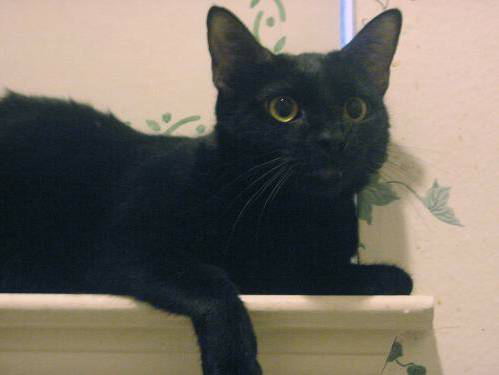

In [35]:
print(train_dataset[0])
train_dataset[0][0]

### Tiền xử lý

Sử dụng `transforms` để chuẩn hóa, thay đổi kích thước, màu ảnh, độ sáng, vv của ảnh

In [36]:
from torchvision import transforms

In [37]:
image_size = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.RandomCrop(image_size),
    # transforms.RandomHorizontalFlip(),
    # transforms.ColorJitter(.3, .3, .3),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

In [39]:
train_dataset = DogCatDataset("../data/raw", "sample/train", transform=transform)

Loading data from ../data/raw/dogscats/sample/train.


Tạo data loader

In [41]:
from torch.utils.data import DataLoader

batch_size = 2 # số phần tử của 1 tập data, có dạng 2^n để tối ưu kiến trúc gpu
workers = 4 # pytorch const

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

## VD train pretrained model

Với tập dataset chó mèo phía trên và model `resnet18`

In [43]:
n_classes = 2

### Load pretrained model

In [42]:
from torchvision import models

model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [44]:
# Freeze giá trị các node của pretrained model 
for param in model.parameters():
    param.requires_grad = False

In [45]:
# print(model)
# Thay đổi layer cuối cùng thành fully connected layer
model.fc = nn.Linear(512, n_classes)

### Loss function

Sử dụng cross entropy cho bài toán phân lớp

In [46]:
# loss_fn = nn.MSELoss()
loss_fn = nn.CrossEntropyLoss()

### Optimizer

Đổi với pretrained model, chỉ optimize các node trong layer cuối cùng


In [49]:
def get_trainable(model_params):
    return (p for p in model_params if p.requires_grad)

In [50]:
optimizer = torch.optim.Adam(
    get_trainable(model.parameters()),
    lr=0.001,
    # momentum=0.9,
)

### Train loop

In [52]:
# phần tạo transform, dataset và dataloader trong mục `Tiền xử lý`

train_trans = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(.3, .3, .3),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
val_trans = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_ds = DogCatDataset("../data/raw", "sample/train", transform=train_trans)
val_ds = DogCatDataset("../data/raw", "sample/valid", transform=val_trans)

train_dl = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
)

val_dl = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
)

Loading data from ../data/raw/dogscats/sample/train.
Loading data from ../data/raw/dogscats/sample/valid.


In [55]:
N_EPOCHS = 4 # số vòng lặp feed data vào network
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for epoch in range(N_EPOCHS):
    
    # train
    model.train()  # IMPORTANT
    
    total_loss, n_correct, n_samples = 0.0, 0, 0
    for batch_i, (X, y) in enumerate(train_dl):
        # copy train và valid data từ ram sang gpu memory
        X, y = X.to(DEVICE), y.to(DEVICE)
        
        optimizer.zero_grad()
        y_ = model(X)
        loss = loss_fn(y_, y)
        loss.backward()
        optimizer.step()
        
        # tính loss và cập nhật optimizer
        _, y_label_ = torch.max(y_, 1)
        n_correct += (y_label_ == y).sum().item()
        total_loss += loss.item() * X.shape[0]
        n_samples += X.shape[0]
    
    # hiển thị quá trình
    print(
        f"Epoch {epoch+1}/{N_EPOCHS} |"
        f"  train loss: {total_loss / n_samples:9.3f} |"
        f"  train acc:  {n_correct / n_samples * 100:9.3f}%"
    )
    
    
    # eval
    model.eval()  # IMPORTANT
    
    total_loss, n_correct, n_samples = 0.0, 0, 0
    with torch.no_grad():  # freeze giá trị các node để tiến hành test/valid
        for X, y in val_dl:
            X, y = X.to(DEVICE), y.to(DEVICE)
                    
            y_ = model(X)
        
            # tính loss và cập nhật optimizer
            _, y_label_ = torch.max(y_, 1)
            n_correct += (y_label_ == y).sum().item()
            loss = loss_fn(y_, y)
            total_loss += loss.item() * X.shape[0]
            n_samples += X.shape[0]

    # hiển thị quá trình
    print(
        f"Epoch {epoch+1}/{N_EPOCHS} |"
        f"  valid loss: {total_loss / n_samples:9.3f} |"
        f"  valid acc:  {n_correct / n_samples * 100:9.3f}%"
    )

Epoch 1/4 |  train loss:     0.288 |  train acc:     81.250%
Epoch 1/4 |  valid loss:     0.418 |  valid acc:     87.500%
Epoch 2/4 |  train loss:     0.620 |  train acc:     62.500%
Epoch 2/4 |  valid loss:     0.290 |  valid acc:     87.500%
Epoch 3/4 |  train loss:     0.416 |  train acc:     75.000%
Epoch 3/4 |  valid loss:     0.321 |  valid acc:     87.500%
Epoch 4/4 |  train loss:     0.641 |  train acc:     56.250%
Epoch 4/4 |  valid loss:     0.337 |  valid acc:     87.500%


## Save & load model

In [ ]:
# save
torch.save(model.state_dict(), 'path/to/model/model_name.pt')

# load
loaded = model.load_state_dict(torch.load('path/to/model/model_name.pt'))

Hướng dẫn train bằng facenet-pytorch
====

## Import thư viện

In [ ]:
pip install facenet-pytorch

In [ ]:
from facenet_pytorch import (
    MTCNN,
    InceptionResnetV1,
    fixed_image_standardization,
    training
)
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import MultiStepLR
from torchvision import (
    datasets,
    transforms
)

## Khởi tạo các biến

In [2]:
batch_size = 32 
epochs = 15 
workers = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_path = 'path/to/data'

## Tiền xử lý data

In [ ]:
transform = transforms.Compose([
                                # transforms.ColorJitter(),
                                # transforms.RandomRotation((-5, 5)),
                                np.float32,
                                transforms.ToTensor(),
                                fixed_image_standardization]) # normalize data ảnh với (x - 127) / 128 với x trong [0, 255]

# khởi tạo dataset
dataset = datasets.ImageFolder(path.join(BASE, data_path), 
                               transform=transform)

# trích label từ dataset
label_dict = dataset.class_to_idx

## Tạo pretrained model

In [ ]:
model_name = 'vggface2'
resnet = InceptionResnetV1(pretrained=model_name,
                           classify=True,
                           num_classes=len(label_dict))

print(resnet)

# thay đổi layer cuối cùng của model bằng fully connected layers
resnet.logits = nn.Sequential(nn.Linear(512, 1024),
                              nn.ReLU(),
                              nn.Linear(1024, 1024),
                              nn.ReLU(),
                              nn.Linear(64, len(label_dict)),
                              nn.Dropout(p=0.2))

## Train model

In [ ]:
optimizer = torch.optim.Adam(resnet.logits.parameters())
scheduler = MultiStepLR(optimizer, [5, 10])

# shuffle dataset
img_idxs = np.arange(len(dataset))
np.random.shuffle(img_idxs)

train_idxs = img_idxs[:int(0.8 * len(img_idxs))]
val_idxs = img_idxs[int(0.8 * len(img_idxs)):]

# tạo tập train và tập valid
train_loader = DataLoader(dataset,
                          num_workers=workers,
                          batch_size=batch_size,
                          sampler=SubsetRandomSampler(train_idxs))
valid_loader = DataLoader(dataset,
                          num_workers=workers,
                          batch_size=batch_size,
                          sampler=SubsetRandomSampler(val_idxs))

loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    # 'fps': training.BatchTimer(),
    'acc': training.accuracy
}

# reset các node của neural net mỗi lần run
optimizer.zero_grad()

for epoch in range(epochs):
    print('-'*60)
    print(f'epochs {epoch + 1}:')
    resnet.train()
    training.pass_epoch(model=resnet,
                        loss_fn=loss_fn,
                        loader=train_loader,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        batch_metrics=metrics,
                        show_running=True,
                        device=device)
    resnet.eval()
    training.pass_epoch(model=resnet,
                        loss_fn=loss_fn,
                        loader=valid_loader,
                        scheduler=scheduler,
                        batch_metrics=metrics,
                        show_running=True,
                        device=device)

## Save model

In [ ]:
torch.save(resnet.state_dict(), 'path/to/model/model_name.pt')